<ipython-input-13-c2caec917887>:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.29158041 0.29158041 0.29158041 ... 0.29158041 0.29158041 0.29158041]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_features.iloc[:, :] = scaler.fit_transform(train_features)
<ipython-input-13-c2caec917887>:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.37351573 -0.72805865 -0.72805865 ... -0.72805865 -0.72805865
  1.37351573]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_features.iloc[:, :] = scaler.fit_transform(train_features)
<ipython-input-13-c2caec917887>:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.69737457  1.43394962  1.43394962 ... -0.69737457  1.43394962
 -0.69737457]'

Encoding labels...
Building 1D-CNN Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model...
Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.0062 - loss: 0.3397 - val_accuracy: 3.4992e-04 - val_loss: 2.2778 - learning_rate: 1.0000e-04
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.0071 - loss: 0.0511 - val_accuracy: 0.0029 - val_loss: 2.1248 - learning_rate: 1.0000e-04
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.0105 - loss: 0.0405 - val_accuracy: 0.0013 - val_loss: 1.0599 - learning_rate: 1.0000e-04
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.0137 - loss: 0.0352 - val_accuracy: 0.0015 - val_loss: 0.1933 - learning_rate: 1.0000e-04
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.0127 - loss: 0.0325 - val_accuracy: 0.0072 - val_loss: 0.0572 - learning_rate: 1.0000e-04
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.0194 - loss: 0.0299 - val_accuracy: 0.0075 - val_loss: 0.0386 - learning_rate: 1.0000e-04
Epoch 7/100
149/149 ━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


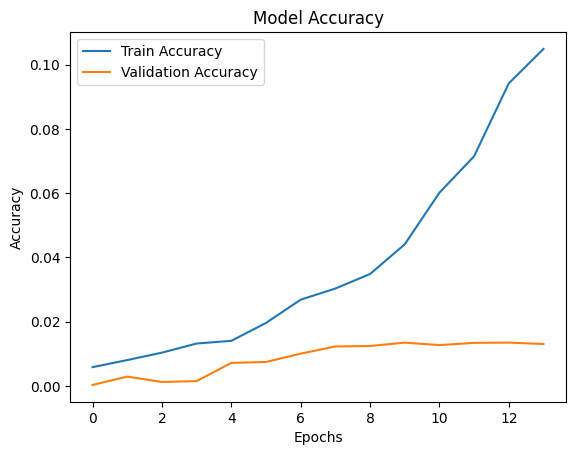

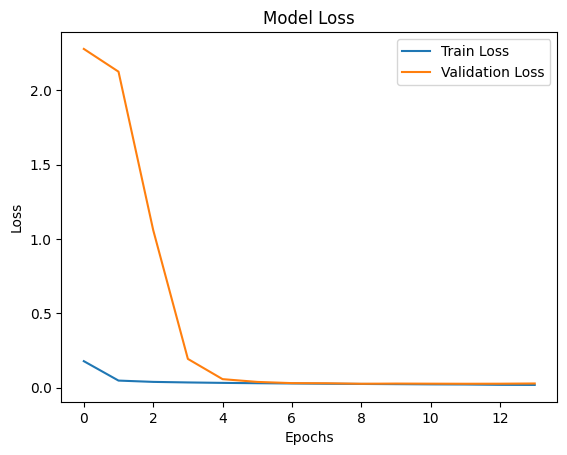

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import log_loss

# Load data
train_features = pd.read_csv("train_features.csv")
train_targets = pd.read_csv("train_targets_scored.csv")

# Use a fraction of data for faster iterations
fraction = 1.0  # Adjust fraction for computational feasibility
train_features = train_features.sample(frac=fraction, random_state=42).reset_index(drop=True)
train_targets = train_targets.loc[train_features.index].reset_index(drop=True)

# Remove 'sig_id' column and process categorical features
train_features = train_features.drop(columns=["sig_id"], errors="ignore")
categorical_cols = ["cp_type", "cp_time", "cp_dose"]
train_features = pd.get_dummies(train_features, columns=categorical_cols, drop_first=True)

# Ensure all features are numeric before scaling (to avoid FutureWarnings)
train_features = train_features.apply(pd.to_numeric, errors='coerce')

# Scale numeric features
scaler = StandardScaler()
train_features.iloc[:, :] = scaler.fit_transform(train_features)

# Drop 'sig_id' from targets
train_targets = train_targets.drop(columns=["sig_id"], errors="ignore")

# Remove any rows with missing values (to avoid issues during training)
train_features = train_features.dropna()
train_targets = train_targets.loc[train_features.index].reset_index(drop=True)

# Train-validation split (no stratification)
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_targets, test_size=0.6, random_state=42
)

# Apply Label Encoding for multi-label classification
print("Encoding labels...")
label_encoder = LabelEncoder()
y_train_encoded = y_train.apply(lambda col: label_encoder.fit_transform(col), axis=0)
y_val_encoded = y_val.apply(lambda col: label_encoder.transform(col), axis=0)

# Reshape the data for CNN (1D-CNN expects 3D input)
X_train_reshaped = np.expand_dims(X_train.values, axis=2)
X_val_reshaped = np.expand_dims(X_val.values, axis=2)

# Define the 1D CNN model
print("Building 1D-CNN Model...")

model = Sequential()

# Add 1D convolutional layers with larger filters and BatchNormalization
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(BatchNormalization())  # Batch Normalization after Conv1D
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Dropout

model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Dropout

model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))  # Dropout

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Sigmoid for multi-label classification

# Compile the model with Nadam optimizer and a learning rate scheduler
model.compile(optimizer=Nadam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model
print("Training the model...")
history = model.fit(
    X_train_reshaped, y_train_encoded,
    epochs=100, batch_size=64,
    validation_data=(X_val_reshaped, y_val_encoded),
    callbacks=[early_stopping, lr_scheduler]
)

# Predict probabilities on validation set
print("Predicting on validation set...")
y_val_pred = model.predict(X_val_reshaped)

# Calculate Log Loss
val_log_loss = log_loss(y_val_encoded, y_val_pred)
print(f"Validation Log Loss: {val_log_loss:.4f}")

# Optional: Plot the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
